In [51]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [52]:
sdir=r'/kaggle/input/poultry/train'
slist=os.listdir(sdir)
classes=[]
filepaths=[]
labels=[]
for d in slist:
    dpath=os.path.join(sdir, d)
    if os.path.isdir(dpath):
        classes.append(d)
class_count=len(classes)
for klass in classes:
    classpath=os.path.join(sdir,klass)
    filelist=os.listdir(classpath)
    for f in filelist:
        fpath=os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(klass)
print ('number of files: ', len(filepaths), '   number of labels: ', len(labels))
file_series=pd.Series(filepaths, name='filepaths')
label_series=pd.Series(labels, name='labels')
df=pd.concat([file_series, label_series], axis=1)
print (df.head())

number of files:  3682    number of labels:  3682
                                           filepaths labels
0  /kaggle/input/poultry/train/salmo/salmo-492_jp...  salmo
1  /kaggle/input/poultry/train/salmo/salmo-422_jp...  salmo
2  /kaggle/input/poultry/train/salmo/salmo-53_jpg...  salmo
3  /kaggle/input/poultry/train/salmo/salmo-260_jp...  salmo
4  /kaggle/input/poultry/train/salmo/salmo-1174_j...  salmo


In [53]:
balance=df['labels'].value_counts()
print (balance)

labels
ncd        949
salmo      938
healthy    906
cocci      889
Name: count, dtype: int64


In [54]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=125)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=125)
print ('train size: ', len(train_df), '  test size: ', len(test_df), '   valid size: ', len(valid_df))
length=len(test_df)

train size:  2945   test size:  368    valid size:  369


In [55]:
batch_size=16
def scalar(x):
    return x/127.5-1 # rescales pixels to range -1 to +1
trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=batch_size, shuffle=True, seed=123)
tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)
valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=batch_size, shuffle=False)
# determine test generator batch size and steps to go through the test set exactly once for predictions
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=tvgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=test_batch_size, shuffle=False)
test_labels=test_gen.labels

Found 2945 validated image filenames belonging to 4 classes.
Found 369 validated image filenames belonging to 4 classes.
Found 368 validated image filenames belonging to 4 classes.


In [56]:
def show_training_samples(gen):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(15, 18)) # Adjusted figure size for better display
    length=len(labels)
    if length<30:   #show maximum of 30 images
        r=length
    else:
        r=30
    for i in range(r):
        plt.subplot(6, 5, i + 1) # Changed grid to 6x5 to accommodate 30 subplots
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=new_dict[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

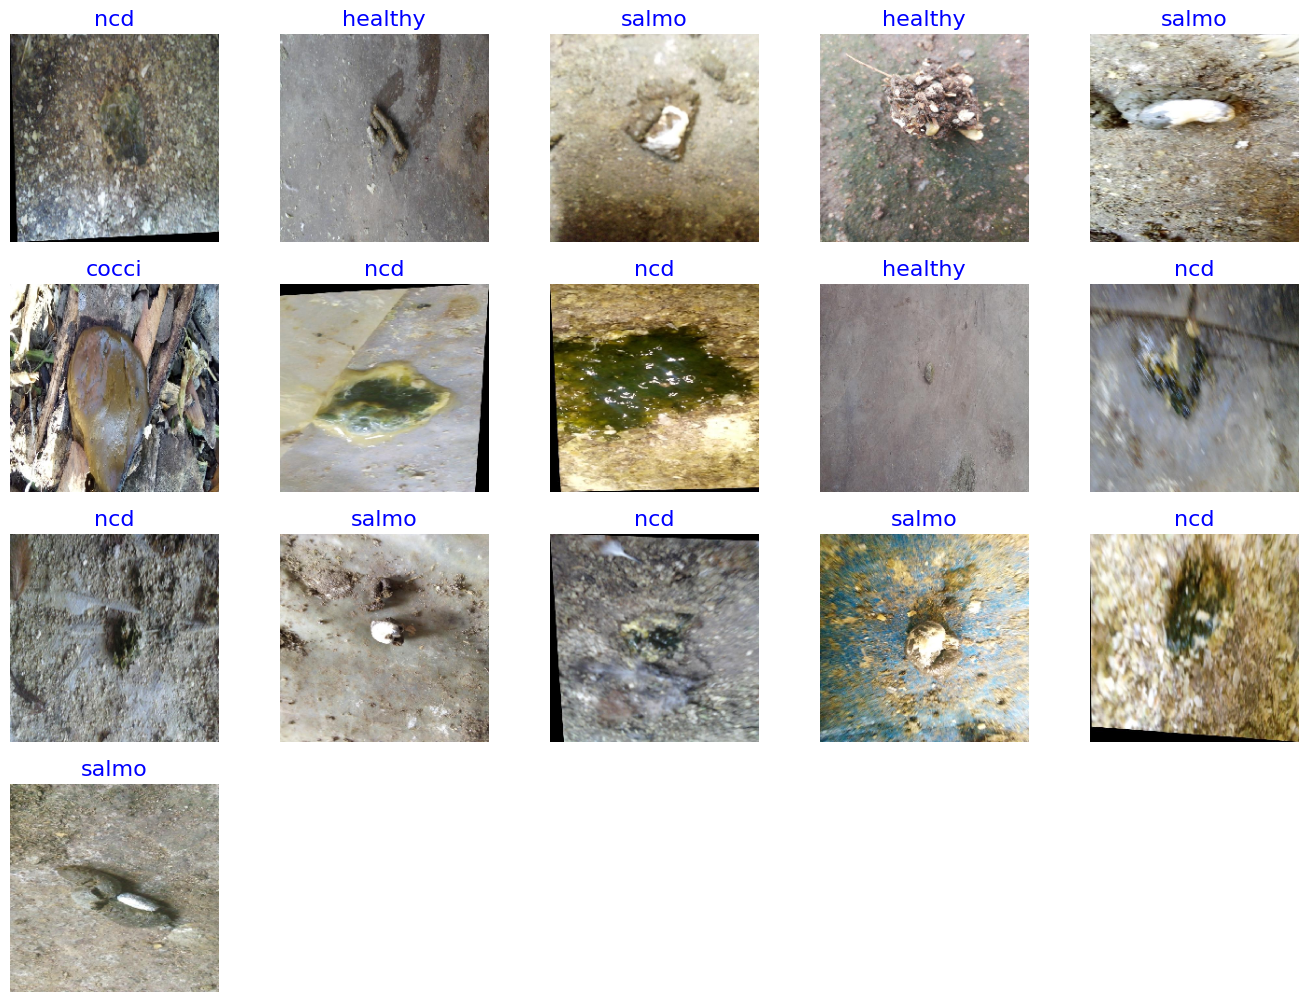

In [57]:
show_training_samples(train_gen)

In [58]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model, Input

# Load DenseNet121 pre-trained model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)  # Add global average pooling
x = layers.Dense(256, activation='relu')(x)  # Optional dense layer for additional learning
outputs = layers.Dense(class_count, activation='softmax')(x)  # Output layer with class_count classes

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         426,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,070,148 (49.86 MB)

 Trainable params: 427,268 (1.63 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [59]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 75s 235ms/step - accuracy: 0.7157 - loss: 0.7747 - val_accuracy: 0.9322 - val_loss: 0.2549
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9307 - loss: 0.2056 - val_accuracy: 0.9512 - val_loss: 0.1731
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9591 - loss: 0.1341 - val_accuracy: 0.9512 - val_loss: 0.1511
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9713 - loss: 0.1029 - val_accuracy: 0.9566 - val_loss: 0.1250
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9795 - loss: 0.0810 - val_accuracy: 0.9566 - val_loss: 0.1203
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9760 - loss: 0.0717 - val_accuracy: 0.9593 - val_loss: 0.1076
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9860 - loss: 0.0600 - val_accuracy: 0.9621 - val_loss: 0.1064
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9911 - loss: 0.0504 - val_accura

In [60]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

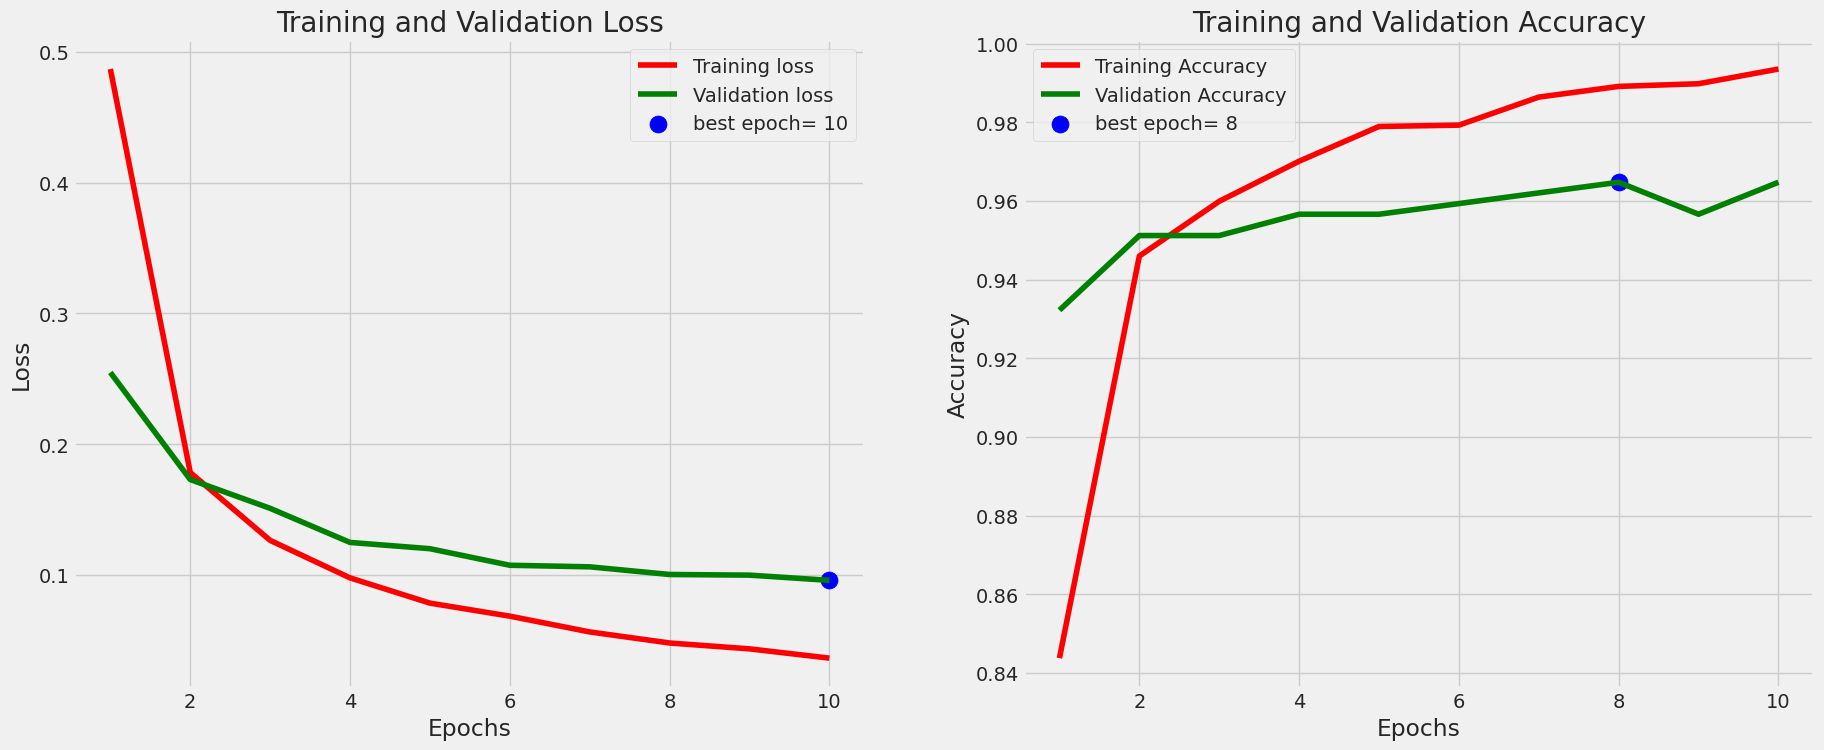

In [61]:
tr_plot(history, 0)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step
Confusion Matrix
[[ 95   0   0   0]
 [  0 101   1   1]
 [  0   1  77   0]
 [  1   3   1  87]]
Classification Report
              precision    recall  f1-score   support

       cocci       0.99      1.00      0.99        95
     healthy       0.96      0.98      0.97       103
         ncd       0.97      0.99      0.98        78
       salmo       0.99      0.95      0.97        92

    accuracy                           0.98       368
   macro avg       0.98      0.98      0.98       368
weighted avg       0.98      0.98      0.98       368



RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

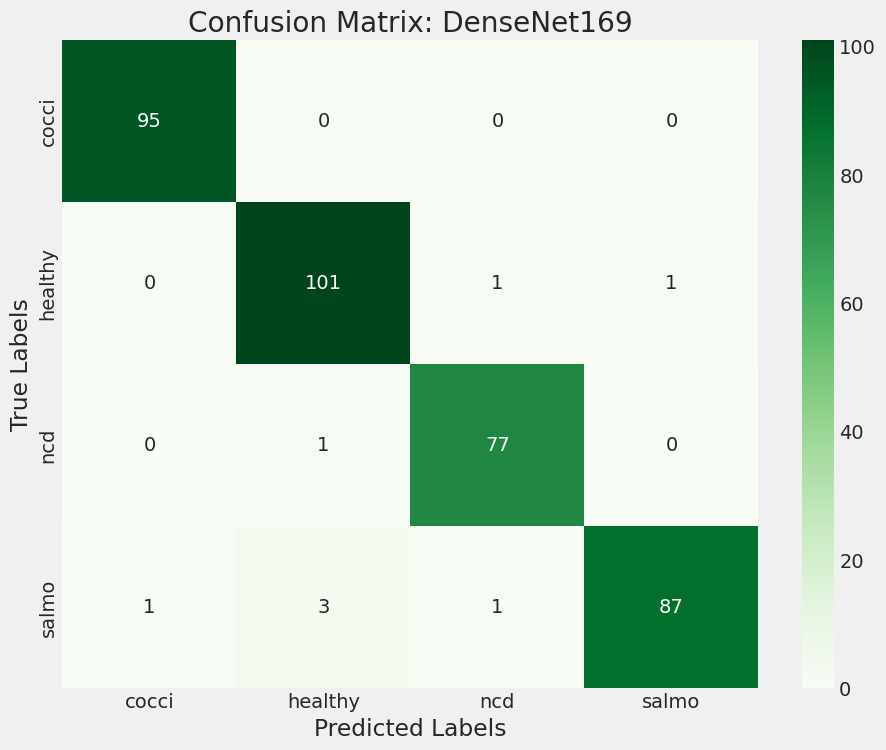

In [62]:
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
class_names = list(test_gen.class_indices.keys())
print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)
print(cm)

print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=class_names))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: DenseNet169')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar(label='Count')
plt.show()

In [ ]:
def print_images(gen):
    class_dict = gen.class_indices
    new_dict = {}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items():
        new_dict[value] = key
    images, labels = next(gen)
    plt.figure(figsize=(15, 20))
    length = len(labels)
    if length < 15:
        r = length
    else:
        r = 15
    for i in range(r):
        plt.subplot(5, 3, i + 1)
        image = (images[i] + 1) / 2
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = new_dict[index]
        pred = model.predict(np.expand_dims(images[i], axis=0))
        pred_index = np.argmax(pred)
        pred_class_name = new_dict[pred_index]
        plt.title(f"True: {class_name}", color='blue', fontsize=14) # Set true class title color to blue
        plt.ylabel(f"Predicted: {pred_class_name}", color='green', fontsize=14) # Set predicted class title color to green and moved it to xlabel for better visibility
        plt.axis('on')
    plt.show()

print_images(train_gen)